<center>
    <h1>Tanzania Water Pumps</h1>
    <h3>The good, the bad and the broken</h3>
</center>
<p>
<center>
    <small>Thomas Hagebols</small>
</center>
</p>

## Problem
- Water pumps in Tanzania break

### Goal
- Improve cost of maintenance
- Prevent break downs

## Solution
- Current
  - Scheduled maintenance
  - Corrective maintenance 
- Aimed
  - Predictive maintenance &uarr;
  - Corrective maintenance &darr;

## Scope
- Classifier to predict pump failure

In [1]:
# Import dependencies
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
from IPython.display import display, Markdown
import numpy as np
import pandas as pd
import qgrid

In [2]:
# Load data
water_pump_set = pd.read_csv("data/water_pump_set.csv")
water_pump_labels = pd.read_csv("data/water_pump_labels.csv")

full_dataset = pd.merge(water_pump_set, water_pump_labels, on="id")
full_dataset.nunique()
water_pump_set.dtypes

id                         int64
amount_tsh               float64
date_recorded             object
funder                    object
gps_height                 int64
installer                 object
longitude                float64
latitude                 float64
wpt_name                  object
num_private                int64
basin                     object
subvillage                object
region                    object
region_code                int64
district_code              int64
lga                       object
ward                      object
population                 int64
public_meeting            object
recorded_by               object
scheme_management         object
scheme_name               object
permit                    object
construction_year          int64
extraction_type           object
extraction_type_group     object
extraction_type_class     object
management                object
management_group          object
payment                   object
payment_ty

## Dataset
- **Records**: 59400
- **Features**: 39
  - **Location info**: longidude, latitude, altitude, basin, subvillage, region, region_code, district_code, lga, ward
  - **Pump info**: waterpoint_type, waterpoint_group, extraction_type, extraction_type_group, extraction_type_class, construction_year, wpt_name, installer
  - **Organizational**: scheme_management, scheme_name, permit, management, management_group
  - **Financial**: funder, payment, payment_type
  - **Water**: amount_tsh, water_quality, quality_group, quantity, quantity_group, source, source_type, source_class
  - **Users**: population, public_meeting
  - **sample info**: date_recorded, recorded_by
- **Labels**: 'Functional', 'Non functional', 'Functional needs repair'

In [3]:
full_dataset = pd.merge(water_pump_set, water_pump_labels, on="id")
full_dataset.nunique()

id                       59400
amount_tsh                  98
date_recorded              356
funder                    1897
gps_height                2428
installer                 2145
longitude                57516
latitude                 57517
wpt_name                 37400
num_private                 65
basin                        9
subvillage               19287
region                      21
region_code                 27
district_code               20
lga                        125
ward                      2092
population                1049
public_meeting               2
recorded_by                  1
scheme_management           12
scheme_name               2696
permit                       2
construction_year           55
extraction_type             18
extraction_type_group       13
extraction_type_class        7
management                  12
management_group             5
payment                      7
payment_type                 7
water_quality                8
quality_

## Questions about dataset
- What is num_private
- Why are there more region codes 27 than regions 21

## Feature selection
- Domain knowledge based (41 -> 27 features)
  - Remove duplicate features
  - Remove unrelated features
- Model based feature selection
  - Decision Tree: Gini efficiency

### Domain knowledge based feature selection
- recorded_by: all recorded by same company
- id: does not hold any predictive value
- wpt_name: every water point has it's own name
- region_code: contains roughly the same data as region
- extraction_type_group and extraction_type_class: contain the same information as extraction_type
- quantity_group: roughly the same as quantity
- quality_group: contains same information as water_quality
- payment_type: roughly same as payment
- source_type and source_class: contains roughly same information as source
- num_private: No clue what this feature means
- subvillage: Not enough observations per subvillage category
- scheme_name: Not enough observations per scheme_name category

In [4]:
drop_list = ['id', 'recorded_by', 'wpt_name', 'region_code',
             'extraction_type_group', 'extraction_type_class',
             'quantity_group', 'quality_group', 'payment_type',
             'source_type', 'source_class',
             'waterpoint_type_group', 'num_private',
             'subvillage', 'scheme_name', 
]

filtered_features = full_dataset.drop(drop_list, axis=1)

## Feature engineering
- Handle missing values
  - Find missing values: **0, nan, unknown, -**
  - Categorical -> most common category
  - Numerical -> mode
- Age of pump during inspection

In [5]:
filtered_features["date_recorded"] = pd.to_datetime(filtered_features["date_recorded"])
filtered_features["age"] = filtered_features["date_recorded"].dt.year.sub(filtered_features["construction_year"], fill_value=-1)

# fixing 0, -, "" and other missing values
filtered_features['amount_tsh'].replace(to_replace=0, value=np.nan, inplace=True)
filtered_features['funder'].replace({"0": np.nan}, inplace=True)
filtered_features['gps_height'].replace(to_replace=0, value=np.nan, inplace=True)
filtered_features['installer'].replace({"0": np.nan, "-": np.nan}, inplace=True)
filtered_features['longitude'].replace({0: np.nan}, inplace=True)
filtered_features['latitude'].replace({-2e-8: np.nan}, inplace=True)
filtered_features['latitude'].replace({-2e-8: np.nan}, inplace=True)
filtered_features['population'].replace({0: np.nan}, inplace=True)
filtered_features['scheme_management'].replace({"None": np.nan, "Company": np.nan}, inplace=True)
filtered_features["age"].replace({-1: np.nan}, inplace=True)

filtered_features.nunique()

amount_tsh              97
date_recorded          356
funder                1896
gps_height            2427
installer             2143
longitude            57515
latitude             57516
basin                    9
region                  21
district_code           20
lga                    125
ward                  2092
population            1048
public_meeting           2
scheme_management       10
permit                   2
construction_year       55
extraction_type         18
management              12
management_group         5
payment                  7
water_quality            8
quantity                 5
source                  10
waterpoint_type          7
status_group             3
age                     64
dtype: int64

In [6]:
qgrid.show_grid(filtered_features, grid_options={'forceFitColumns': False, 'defaultColumnWidth': 100,})

QgridWidget(grid_options={'defaultColumnWidth': 100, 'boldIndex': True, 'enableColumnReorder': False, 'fullWid…

### Fix types

In [7]:
numeric_features = ["amount_tsh", "gps_height", "longitude",
                    "latitude", "district_code", "population",
                    "construction_year", "age", "date_recorded"]

categorical_features = ["funder", "installer", "basin",
                        "region", "lga", "ward", "public_meeting",
                        "scheme_management", "permit", "extraction_type",
                        "management", "management_group", "payment",
                        "water_quality", "quantity", "source",
                        "waterpoint_type", "status_group"]

# Convert to categorical features
for feature in categorical_features:
    filtered_features[feature] = filtered_features[feature].astype("category")

# Convert datetime to float
filtered_features["date_recorded"] = pd.to_numeric(filtered_features["date_recorded"])

filtered_features.dtypes

amount_tsh            float64
date_recorded           int64
funder               category
gps_height            float64
installer            category
longitude             float64
latitude              float64
basin                category
region               category
district_code           int64
lga                  category
ward                 category
population            float64
public_meeting       category
scheme_management    category
permit               category
construction_year       int64
extraction_type      category
management           category
management_group     category
payment              category
water_quality        category
quantity             category
source               category
waterpoint_type      category
status_group         category
age                   float64
dtype: object

## Preprocessing
- Replace missing values
- Convert categorical features to be interpretable for sklearn

In [8]:
X = filtered_features.drop("status_group", axis=1)
Y = filtered_features["status_group"]

try:
    categorical_features.remove("status_group")
except:
    pass

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

X = preprocessor.fit_transform(X)

X = pd.DataFrame(X, columns=numeric_features+categorical_features)

for feature in categorical_features:
    X[feature] = LabelEncoder().fit_transform(X[feature])

In [9]:
qgrid.show_grid(X, grid_options={'forceFitColumns': False, 'defaultColumnWidth': 100,})

QgridWidget(grid_options={'defaultColumnWidth': 100, 'boldIndex': True, 'enableColumnReorder': False, 'fullWid…

## Model based feature selection

In [10]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, test_size=.2)

clf = tree.DecisionTreeClassifier()
clf = clf.fit(x_train, y_train)

y_hat = clf.predict(x_test)
accuracy_score(y_test, y_hat)

feature_importance = pd.DataFrame(clf.feature_importances_, index=X.columns, columns=["Gini index"])

In [11]:
display(feature_importance)

,Gini index
amount_tsh,0.008359
gps_height,0.063028
longitude,0.136628
latitude,0.135194
district_code,0.008812
population,0.041697
construction_year,0.026533
age,0.023274
date_recorded,0.047471
funder,0.035289


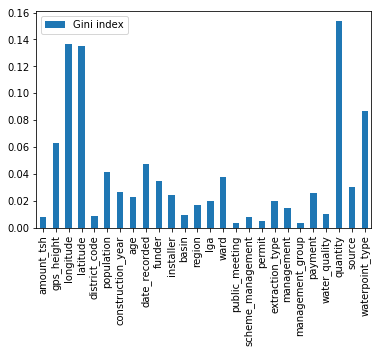

In [12]:
feature_importance.plot.bar()
plt.show()

In [13]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
    else:
#         print('Confusion matrix, without normalization')
        pass

    # print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    ax.set_title("Confusion matrix")
    return ax

## Training
- Unbalanced dataset
  - SMOTE (Synthetic Minority Over-sampling Technique)
- Decision tree for interpretability
- Grid search (depth, min sample split, min leaf split)

In [14]:
# Create train and test model
# Smote is an oversampling technique which adds noise to create more samples
model = tree.DecisionTreeClassifier()
params = {"max_depth":[5, 10, 30, 50],
          "min_samples_split": [2,4,8],
          "min_samples_leaf": [2,4,8]}
grid = GridSearchCV(model,
                   param_grid=params,
                   cv=3,)
pipeline = make_pipeline(SMOTE(),
                         grid)

pipeline.fit(x_train, y_train)
best_model = pipeline.steps[1][1].best_estimator_
best_model

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=30,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=4,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [15]:
# Train the best model found in the grid search
best_model = pipeline.steps[1][1].best_estimator_
best_model.fit(x_train, y_train)

y_hat = best_model.predict(x_test)

# Evaluate results
precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_hat)
precision = pd.Series(precision, index=y_test.cat.categories, name="precision")
recall = pd.Series(recall, index=y_test.cat.categories, name="recall")
precision_recall = pd.concat([precision, recall], axis=1)

## Evaluation
- Precision: How many selected items are relevant?
- Recall: How many relevant items are selected?
- Confusion matrix
- Accuracy

In [16]:
display(Markdown("**Accuracy**: {:4f}".format(accuracy_score(y_test, y_hat))))

**Accuracy**: 0.755892

In [17]:
display(precision_recall)

,precision,recall
functional,0.776750,0.833644
functional needs repair,0.390244,0.350634
non functional,0.789486,0.723134


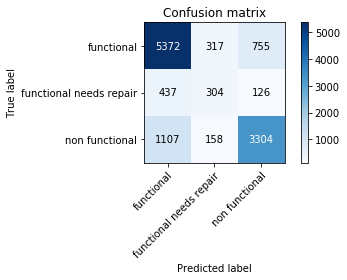

In [18]:
plot = plot_confusion_matrix(y_test, y_hat, list(y_test.cat.categories))

## Conclusion
- Failure can be predicted in most cases
- Improve uptime
- Decrease cost

## Future directions
- Better feature engineering
  - Latitude, longitude and altitude are highly predictive
    - Fill out missing data using Google maps geolocate (see code example)
- Cross validated random search
  - Based on F1 measure or recall
- Incorporate this into existing systems?
- Rebuild using proper database scheme?
- Make a Flask / Djang web app

    from geopy.geocoders import Nominatim
    from time import sleep

    geolocator = Nominatim(user_agent="test")
    lga_latlong = {}
    for location in filtered_features['lga'].unique():
        sleep(0.2)
        geo_loc = geolocator.geocode("{} Tanzania".format(location))

        if geo_loc is not None:
            lga_latlong[location] = {'latitude': geo_loc.latitude, 'longitude': geo_loc.longitude}

    lga_latlong